In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Load data
df = pd.read_csv("acled_sample.csv")  # or reuse BigQuery fetch if preferred
df = df[['event_description', 'event_type']].dropna()



In [3]:
# Encode target
df['event_type'] = df['event_type'].astype('category')
df['label'] = df['event_type'].cat.codes

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    df['event_description'],
    df['label'],
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)


In [4]:
# TF-IDF (Term Frequency - Inverse Document Frequency) converts raw text into a matrix of feature weights.
# It reflects how important a word or phrase is to a document relative to the entire corpus.
# Common words like "the" get low scores, while rare, informative terms get higher weights.
# This helps the model focus on meaningful content rather than just frequent words.


# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)


TF-IDF shape (train): (16000, 5000)


In [5]:
# Inspect some vocabulary
print("Number of features:", len(vectorizer.vocabulary_))
print("Example features:")
print(sorted(vectorizer.vocabulary_.keys())[:100])

Number of features: 5000
Example features:
['000', '10', '10 dec', '10 december', '10 people', '10 split', '100', '100 people', '100 persons', '100 workers', '1000', '101', '1080', '1080 euros', '11', '11 december', '11th', '11th month', '12', '12 december', '120', '120mm', '12th', '13', '13 december', '14', '14 december', '15', '15 december', '15 nov', '15 people', '150', '150 people', '16', '16 december', '17', '17 december', '18', '18 december', '19', '19 december', '20', '20 december', '20 people', '200', '200 people', '2011', '2018', '2019', '2019 following', '2020', '2020 10', '2020 100', '2020 15', '2020 150', '2020 20', '2020 200', '2020 2021', '2020 250', '2020 30', '2020 300', '2020 40', '2020 400', '2020 50', '2020 500', '2020 60', '2020 70', '2020 80', '2020 activists', '2020 afghan', '2020 al', '2020 ambazonian', '2020 anti', '2020 armed', '2020 banner', '2020 bjp', '2020 boko', '2020 buenos', '2020 cadres', '2020 caracas', '2020 citizens', '2020 ciudad', '2020 civil', '20

In [6]:
#feature names and their tf-idf scores for a single example
sample_idx = 0
sample_desc = X_train.iloc[sample_idx]
sample_vector = X_train_tfidf[sample_idx]

# Convert to a dense array and match with feature names
feature_array = vectorizer.get_feature_names_out()
tfidf_scores = sample_vector.toarray()[0]

# Show non-zero scores for this sample
nonzero = [(feature_array[i], tfidf_scores[i]) for i in tfidf_scores.nonzero()[0]]
sorted_scores = sorted(nonzero, key=lambda x: x[1], reverse=True)

print(f"TF-IDF scores for:\n\"{sample_desc[:100]}...\"\n")
for word, score in sorted_scores[:10]:
    print(f"{word}: {score:.3f}")


TF-IDF scores for:
"On 16 December 2020, Houthi forces targeted residential neighborhoods in Hays city and Bayt Maghari ..."

hays: 0.401
strikes: 0.358
houthi: 0.272
rpgs: 0.217
forces targeted: 0.214
hays al: 0.214
bayt: 0.202
shells: 0.195
neighborhoods: 0.193
mortar: 0.192


In [7]:
# Logistic Regression is a linear classifier that works well for text classification,
# especially when using sparse features like TF-IDF.
# It learns weights for each word-feature per class.

# max_iter=1000 increases the number of iterations used in optimization (default is 100),
# which prevents convergence warnings on large datasets with many features.
# Docs: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
clf = LogisticRegression(max_iter=1000)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

Classification Report:

                            precision    recall  f1-score   support

                   Battles       0.88      0.93      0.91       588
Explosions/Remote violence       0.95      0.94      0.94       346
                  Protests       0.97      1.00      0.98      2147
                     Riots       0.90      0.67      0.77       240
    Strategic developments       0.96      0.82      0.89       230
Violence against civilians       0.88      0.89      0.89       449

                  accuracy                           0.94      4000
                 macro avg       0.92      0.87      0.90      4000
              weighted avg       0.94      0.94      0.94      4000



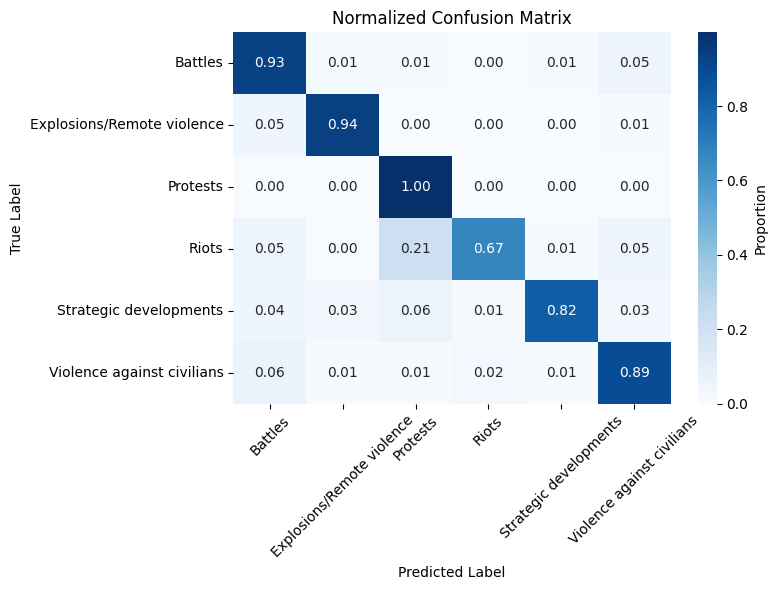

In [8]:
# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=df['event_type'].cat.categories))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')  # normalize rows

# Labels
labels = df['event_type'].cat.categories

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels, yticklabels=labels,
            cbar_kws={"label": "Proportion"})

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# This heatmap shows the normalized confusion matrix.
# Each row represents the true class, and each column the predicted class.
# Values are proportions, so a value of 0.95 on the diagonal means 95% of that class was correctly predicted.
# Off-diagonal values show misclassifications — for example, if 'Riots' → 'Protests' shows 0.20,
# it means 20% of actual Riots were predicted as Protests.


In [9]:
import numpy as np

# Get the class labels and feature names
class_labels = df['event_type'].cat.categories
feature_names = vectorizer.get_feature_names_out()

# Set how many top words to show
top_n = 10

for i, class_name in enumerate(class_labels):
    top_features = np.argsort(clf.coef_[i])[-top_n:][::-1]
    print(f"\n🔹 Top {top_n} features for class: {class_name}")
    for j in top_features:
        print(f"  {feature_names[j]:<25}  coef: {clf.coef_[i][j]:.4f}")



🔹 Top 10 features for class: Battles
  clashed                    coef: 7.1320
  clash                      coef: 4.4009
  clashes                    coef: 4.1766
  killed                     coef: 3.9628
  fatalities                 coef: 3.7461
  militants                  coef: 3.4466
  exchanged                  coef: 3.1905
  forces                     coef: 2.8443
  shoot                      coef: 2.8224
  arms                       coef: 2.7483

🔹 Top 10 features for class: Explosions/Remote violence
  shelled                    coef: 4.8390
  ied                        coef: 4.3531
  airstrikes                 coef: 3.8352
  grenade                    coef: 3.6513
  planted                    coef: 3.5856
  airstrike                  coef: 3.5038
  detonated                  coef: 3.2952
  targeted                   coef: 3.0567
  landmine                   coef: 3.0112
  casualties                 coef: 2.9540

🔹 Top 10 features for class: Protests
  protest                 